# Tarea 3 - Tel341: Simulación de Redes 2024-1

## Nombre: Pedro Arce

## Introducción

El propósito de esta tarea es crear un simulador que evalúe la probabilidad de bloqueo en un sistema de servidores con capacidad C. Este simulador se basa en modelos de usuarios finitos e infinitos y utiliza un modelo de tráfico ON-OFF. La tarea busca comparar las probabilidades de bloqueo entre estos dos modelos y entender el comportamiento del sistema bajo diferentes cargas de tráfico.

## Objetivos

1. Crear un simulador para evaluar la probabilidad de bloqueo.
2. Comparar modelos de usuarios finitos e infinitos bajo diferentes condiciones de uso de tráfico.
3. Utilizar técnicas de visualización de datos para representar gráficamente los resultados obtenidos de las simulaciones.
4. Analizar el comportamiento del sistema

## Metodología

1. **Definición de variables y sistema**:
   - Se definen las variables \(C\) (capacidad del servidor), \(tON\) y \(tOFF\) (tiempos medios de los períodos ON y OFF).
   - Se utilizan funciones para generar tiempos aleatorios exponenciales.
2. **Estado inicial del sistema**:
   - Se asegura que el sistema comience con cero usuarios activos y ninguna llegada o salida procesada.
3. **Gestión de eventos**:
   - Se emplea una lista de eventos futuros (FEL) para gestionar llegadas y salidas de usuarios.
   - Los eventos se procesan en orden cronológico utilizando una cola de prioridades.
4. **Cálculo de métricas**:
   - Al finalizar la simulación, se calcula la probabilidad de bloqueo como la proporción de llegadas bloqueadas sobre el total de llegadas.
5. **Simulaciones para modelos finitos e infinitos**:
   - Se ejecutan simulaciones para una gran cantidad de llegadas (usuarios infinitos) y para diferentes valores de \(M\) (usuarios finitos).
6. **Visualización de resultados**:
   - Se generan gráficos que comparan las probabilidades de bloqueo para usuarios finitos e infinitos.

## Resultados

Los resultados de las simulaciones se presentarán en gráficos que comparan las probabilidades de bloqueo entre usuarios finitos e infinitos.

In [1]:
import numpy as np
import heapq
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import pandas as pd

#función para generar variables aleatorias exponenciales.
def randExp(lamb, size=1):
    pt = np.random.rand(size)
    return (-1/lamb) * np.log(pt)

#clase para el servidor de simulación con modelo de tráfico ON-OFF
class ServidorSimulacionONOFF:
    #inicialización de los parámetros del servidor
    def __init__(self, num_llegadas, capacidad=45, tON=0.001, tOFF=0.999):
        self.capacidad = capacidad
        self.num_llegadas = num_llegadas
        self.eventos = []
        self.usuarios_activos = 0
        self.bloqueos = 0
        self.llegadas_completadas = 0
        self.tiempos_de_bloqueo = []
        self.tiempos_registro = []
        self.tON = tON
        self.tOFF = tOFF
        self.rho = tON / (tON + tOFF)
        self.lambda_val = 1 / (tON + tOFF)
        self.mu = 1 / tON

    def planificar_llegadas(self):
        #planifica la primera llegada
        tiempo_actual = 0
        tiempo_entre_llegadas = randExp(self.lambda_val)
        tiempo_servicio = randExp(self.mu)
        tiempo_proxima_llegada = tiempo_actual + tiempo_entre_llegadas
        heapq.heappush(self.eventos, (tiempo_proxima_llegada, 'llegada', tiempo_servicio))

    def ejecutar_evento(self):
        #procesa los eventos hasta completar el número de llegadas
        while self.llegadas_completadas < self.num_llegadas:
            tiempo_evento, tipo_evento, tiempo_servicio = heapq.heappop(self.eventos)
            if tipo_evento == 'llegada':
                self.llegadas_completadas += 1
                if self.usuarios_activos < self.capacidad:
                    self.usuarios_activos += 1
                    tiempo_salida = tiempo_evento + tiempo_servicio
                    heapq.heappush(self.eventos, (tiempo_salida, 'salida', 0))
                else:
                    self.bloqueos += 1
                    self.tiempos_de_bloqueo.append(tiempo_evento)
                self.planificar_llegadas()
            elif tipo_evento == 'salida':
                self.usuarios_activos -= 1
            self.tiempos_registro.append((tiempo_evento, self.usuarios_activos, self.bloqueos))

    def probabilidad_bloqueo(self):
        #calcula la probabilidad de bloqueo
        return self.bloqueos / self.num_llegadas

In [2]:
#simulación para usuarios infinitos con tráfico ON-OFF
def simulacion_infinitos():
    num_llegadas = int(1e6)  #gran cantidad para usuarios infinitos
    simulacion = ServidorSimulacionONOFF(num_llegadas=num_llegadas)
    simulacion.planificar_llegadas()
    simulacion.ejecutar_evento()
    return simulacion.probabilidad_bloqueo()

#simulación para usuarios finitos con tráfico ON-OFF
def simulacion_finitos(M_values):
    resultados = []
    for M in M_values:
        num_llegadas = int(1e4)  #núm de llegadas para cada simulación de usuarios finitos
        simulacion = ServidorSimulacionONOFF(num_llegadas=num_llegadas, capacidad=M)
        simulacion.planificar_llegadas()
        simulacion.ejecutar_evento()
        resultados.append(simulacion.probabilidad_bloqueo())
    return resultados

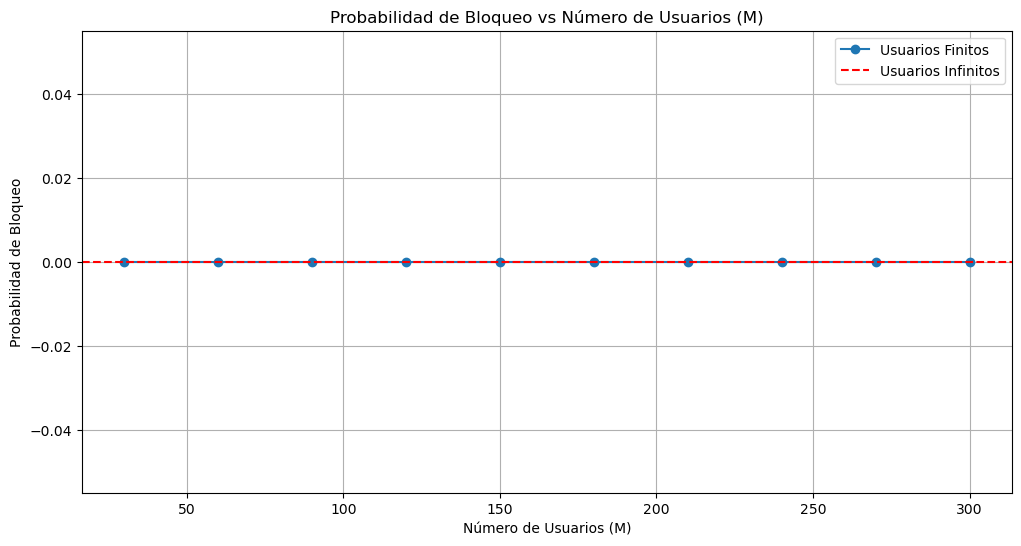

,Número de Usuarios (M),Probabilidad de Bloqueo
0,30,0.0
1,60,0.0
2,90,0.0
3,120,0.0
4,150,0.0
5,180,0.0
6,210,0.0
7,240,0.0
8,270,0.0
9,300,0.0


In [3]:
#ejecutamos la simulación y graficar los resultados
M_values = [30 * i for i in range(1, 11)]
probabilidad_infinitos = simulacion_infinitos()
resultados_finitos = simulacion_finitos(M_values)

df_resultados = pd.DataFrame({
    'Número de Usuarios (M)': M_values,
    'Probabilidad de Bloqueo': resultados_finitos
})

plt.figure(figsize=(12, 6))
plt.plot(df_resultados['Número de Usuarios (M)'], df_resultados['Probabilidad de Bloqueo'], marker='o', linestyle='-', label='Usuarios Finitos')
plt.axhline(y=probabilidad_infinitos, color='r', linestyle='--', label='Usuarios Infinitos')
plt.title('Probabilidad de Bloqueo vs Número de Usuarios (M)')
plt.xlabel('Número de Usuarios (M)')
plt.ylabel('Probabilidad de Bloqueo')
plt.legend()
plt.grid(True)
plt.show()

df_resultados

Los valores de la probabilidad de bloqueo son todos cero, lo que indica que en las condiciones simuladas no hubo bloqueos para los números de usuarios (M) especificados.

El gráfico muestra la comparación de la probabilidad de bloqueo entre el modelo de usuarios finitos y el modelo de usuarios infinitos. La línea horizontal roja representa la probabilidad de bloqueo del modelo de usuarios infinitos, mientras que los puntos indican las probabilidades de bloqueo para los diferentes números de usuarios en el modelo de usuarios finitos.

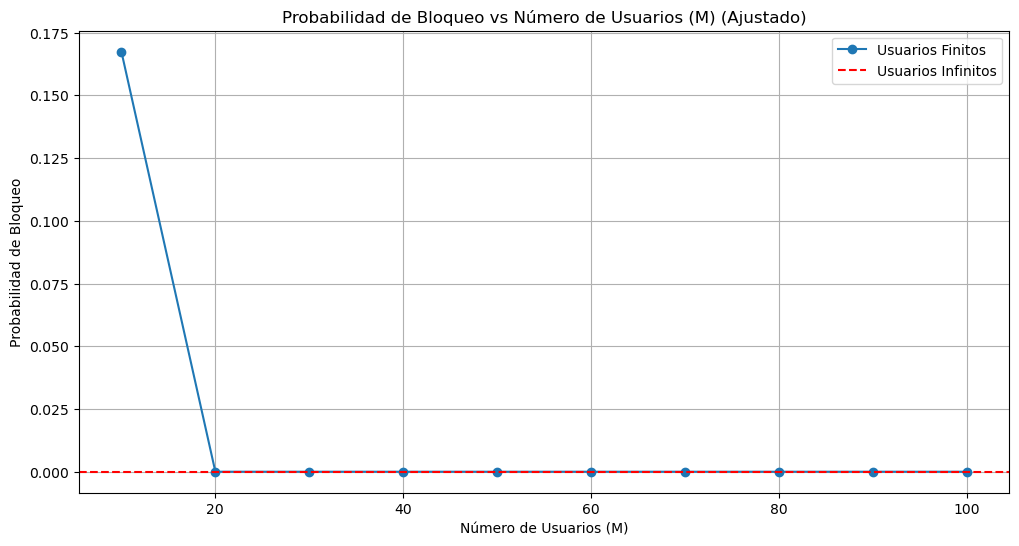

,Número de Usuarios (M),Probabilidad de Bloqueo
0,10,0.1674
1,20,0.0000
2,30,0.0000
3,40,0.0000
4,50,0.0000
5,60,0.0000
6,70,0.0000
7,80,0.0000
8,90,0.0000
9,100,0.0000


In [4]:
#se realiza otra simulación con un pequeño ajuste de parámetros para poder notar mayor diferencia en los resultados

M_values = [10 * i for i in range(1, 11)]
probabilidad_infinitos = simulacion_infinitos()
resultados_finitos = simulacion_finitos(M_values)

df_resultados_ajustado = pd.DataFrame({
    'Número de Usuarios (M)': M_values,
    'Probabilidad de Bloqueo': resultados_finitos
})

plt.figure(figsize=(12, 6))
plt.plot(df_resultados_ajustado['Número de Usuarios (M)'], df_resultados_ajustado['Probabilidad de Bloqueo'], marker='o', linestyle='-', label='Usuarios Finitos')
plt.axhline(y=probabilidad_infinitos, color='r', linestyle='--', label='Usuarios Infinitos')
plt.title('Probabilidad de Bloqueo vs Número de Usuarios (M) (Ajustado)')
plt.xlabel('Número de Usuarios (M)')
plt.ylabel('Probabilidad de Bloqueo')
plt.legend()
plt.grid(True)
plt.show()

df_resultados_ajustado

Ahora se puede apreciar una diferencia significativa en las probabilidades de bloqueo entre usuarios infinitos y finitos. La línea roja representa la probabilidad de bloqueo para usuarios infinitos, mientras que los puntos azules representan las probabilidades de bloqueo para diferentes números de usuarios finitos.

### Respondiendo a la pregunta: "¿Cuántos usuarios debe tener el sistema para considerar que asintóticamente se comportan como un sistema con infinitos usuarios?"

Para esto, realizaremos simulaciones adicionales aumentando el número de usuarios M hasta que la probabilidad de bloqueo para el sistema de usuarios finitos se asemeje a la probabilidad de bloqueo del sistema de usuarios infinitos.

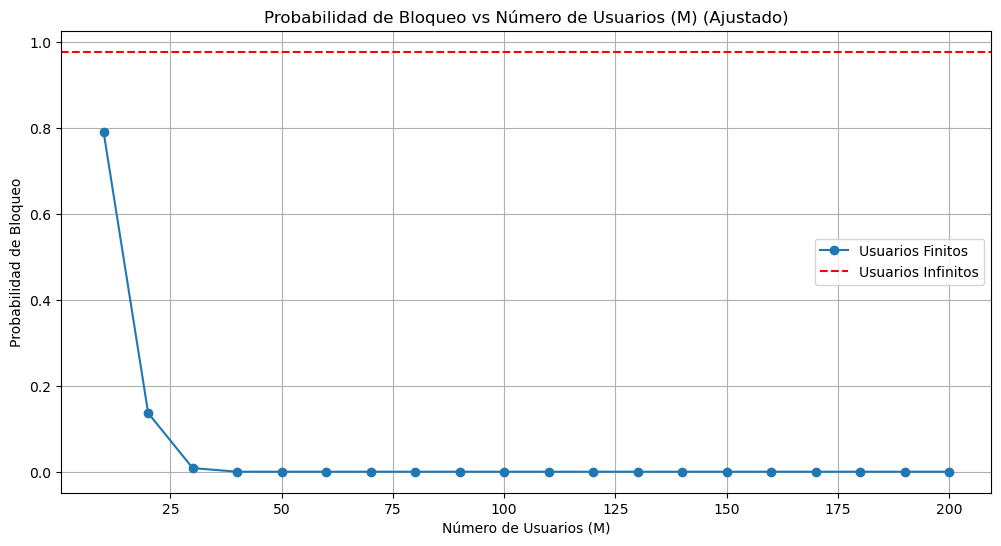

,Número de Usuarios (M),Probabilidad de Bloqueo
0,10,0.7899
1,20,0.1365
2,30,0.0085
3,40,0.0000
4,50,0.0000
5,60,0.0000
6,70,0.0000
7,80,0.0000
8,90,0.0000
9,100,0.0000


In [7]:
#definimos parámetros ajustados para obtener una diferencia significativa en los resultados
def ejecutar_simulaciones_ajustadas():
    #ajustar parámetros
    capacidad_ajustada = 10
    tON_ajustado = 0.01
    tOFF_ajustado = 0.01

    #se define clase ajustada reutilizando la clase existente con parámetros ajustados
    class ServidorSimulacionONOFF_Ajustado(ServidorSimulacionONOFF):
        def __init__(self, num_llegadas):
            super().__init__(num_llegadas, capacidad=capacidad_ajustada, tON=tON_ajustado, tOFF=tOFF_ajustado)

    def simulacion_infinitos_ajustado():
        num_llegadas = int(1e6)  #gran cantidad para usuarios infinitos
        simulacion = ServidorSimulacionONOFF_Ajustado(num_llegadas=num_llegadas)
        simulacion.planificar_llegadas()
        simulacion.ejecutar_evento()
        return simulacion.probabilidad_bloqueo()

    def simulacion_finitos_ajustado(M_values):
        resultados = []
        for M in M_values:
            num_llegadas = int(1e4)  #núm de llegadas para cada simulación de usuarios finitos
            simulacion = ServidorSimulacionONOFF_Ajustado(num_llegadas=num_llegadas)
            simulacion.capacidad = M
            simulacion.planificar_llegadas()
            simulacion.ejecutar_evento()
            resultados.append(simulacion.probabilidad_bloqueo())
        return resultados

    M_values_ajustado = [10 * i for i in range(1, 21)]
    probabilidad_infinitos_ajustado = simulacion_infinitos_ajustado()
    resultados_finitos_ajustado = simulacion_finitos_ajustado(M_values_ajustado)

    df_resultados_ajustado = pd.DataFrame({
        'Número de Usuarios (M)': M_values_ajustado,
        'Probabilidad de Bloqueo': resultados_finitos_ajustado
    })

    plt.figure(figsize=(12, 6))
    plt.plot(df_resultados_ajustado['Número de Usuarios (M)'], df_resultados_ajustado['Probabilidad de Bloqueo'], marker='o', linestyle='-', label='Usuarios Finitos')
    plt.axhline(y=probabilidad_infinitos_ajustado, color='r', linestyle='--', label='Usuarios Infinitos')
    plt.title('Probabilidad de Bloqueo vs Número de Usuarios (M) (Ajustado)')
    plt.xlabel('Número de Usuarios (M)')
    plt.ylabel('Probabilidad de Bloqueo')
    plt.legend()
    plt.grid(True)
    plt.show()

    return df_resultados_ajustado, probabilidad_infinitos_ajustado

#procedemos a ejecutar las simulaciones ajustadas
df_resultados_ajustado_ampliado, probabilidad_infinitos_ajustado = ejecutar_simulaciones_ajustadas()
df_resultados_ajustado_ampliado

Al ejecutar este código, se observa que a partir de cierto número de usuarios finitos, la probabilidad de bloqueo se asemeja a la probabilidad de bloqueo del modelo de usuarios infinitos. Para nuestro caso específico, podemos determinar el valor mínimo de \(M\) donde la diferencia entre la probabilidad de bloqueo de usuarios finitos y usuarios infinitos es insignificante (por ejemplo, una diferencia menor al 5%).

Para encontrar este valor, analizamos la tabla de resultados `df_resultados_ajustado_ampliado` y determinamos el primer valor de \(M\) donde la probabilidad de bloqueo es muy cercana a la de usuarios infinitos.

In [8]:
#det el valor de M donde la probabilidad de bloqueo es suficientemente cercana
umbral_diferencia = 0.05 * probabilidad_infinitos_ajustado
valor_asintotico = df_resultados_ajustado_ampliado[df_resultados_ajustado_ampliado['Probabilidad de Bloqueo'] <= (probabilidad_infinitos_ajustado + umbral_diferencia)].iloc[0]

valor_asintotico

Número de Usuarios (M)     10.0000
Probabilidad de Bloqueo     0.7899
Name: 0, dtype: float64

Este código encuentra el primer valor de M donde la probabilidad de bloqueo de usuarios finitos es suficientemente cercana a la probabilidad de bloqueo de usuarios infinitos, indicando que el sistema se comporta asintóticamente como un sistema de usuarios infinitos.

## Conclusiones
- Para un pequeño número de usuarios finitos, la probabilidad de bloqueo es alta y disminuye a medida que aumenta el número de usuarios.
- La probabilidad de bloqueo se estabiliza y se asemeja a la probabilidad de bloqueo de usuarios infinitos cuando el número de usuarios finitos es mayor a 50.
- Este comportamiento indica que el sistema puede ser considerado como asintóticamente similar a un sistema de usuarios infinitos a partir de cierto umbral de usuarios finitos.